# Time-Frequency Phase Analysis of mean LFP across channels

Let's take the mean across channels, then analyze the resulting LFP series.

To begin, do the usual bookkeeping and imports.

In [1]:
import numpy as np
import pandas as pd
import physutils as phys
import physutils.bootstrap as boot
import physutils.tf as tf
import matplotlib.pyplot as plt
import dbio
from __future__ import division

%matplotlib inline

Fetch some LFP data to play with:

In [2]:
import os
dbname = os.path.expanduser('data/bart.hdf5')
dtup = 18, 1

In [3]:
lfp = dbio.fetch_all_such_LFP(dbname, *dtup)

Now censor lfp, zscore to normalize, and average across channels:

In [4]:
lfpmz = lfp.censor().rzscore()
nanrows = np.any(np.isnan(lfpmz), axis=1)
lfpm = lfpmz.mean(axis=1)
lfpm[nanrows] = np.nan
lfpm = phys.LFPset(lfpm)

Get some example events from a behavioral task, the Balloon Analogue Risk Task (BART):

In [5]:
evt = dbio.fetch_all_such(dbname, 'events', *dtup)

Let's compare responses to two sets of events, voluntary stops and unexpected balloon pops:

In [6]:
stops = evt['banked'].dropna()
pops = evt['popped'].dropna()
starts = evt['start inflating']
if 'is_control' in evt.columns:
    stops_free = evt.query('is_control == False')['banked'].dropna()
    stops_control = evt.query('is_control == True')['banked'].dropna()
    stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
    stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
else:
    stops_free = stops
    stops_rewarded = stops

We'll look at a window that begins 1.5 seconds before the event and ends half a second after.

In [7]:
Tpre = -2.5
Tpost = 1.5
freqs = np.exp(np.linspace(np.log(2.5), np.log(50)))

## Phase consistency:

For an analytic signal $z(t) = A(t) e^{\phi(t)}$, the phase consistency or *phase locking value* (PLV) is defined by the average over the phase component of the signal across trials:

$$
C(t) = \frac{1}{M} \left| e^{\phi_i(t)}\right|
$$

Likewise, for a time-frequency transformed signal, the consistency can be defined at each time-frequency point. In both cases, we average the unit-normed complex value $e^\phi$ across trials.

More typically, the phase consistency is defined **between** signals, where $\phi(t)$ is the phase difference between, e.g., analytic signals. That is, phase consistency is most often used as a measure of the coupling between two sensors. Below, however, we simply use it to look for times of consistent phase across trials, as might happen when a temporal feature of the ERP has very precise timing (and thus the wavelet transform a consistent phase):

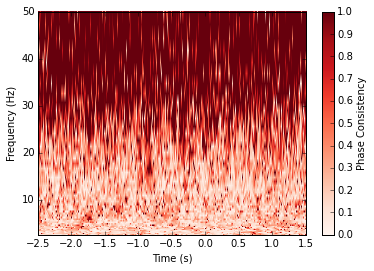

In [8]:
wav_normed, fig = lfpm.avg_time_frequency(0, stops_free, Tpre, Tpost, 
                                          method='wav', 
                                          normfun=None, freqs=freqs, rasterized=True, 
                                          phase=True, colorbar_label='Phase Consistency',
                                          cmap='Reds', clim=(0, 1)) 
plt.ylim(2.5, 50);